### Inference API

In [36]:
from unet import *
from pathlib import Path
import re
import matplotlib.pyplot as plt
import random

In [2]:
#Important Paths
model_dir = "/mnt/d/mishaal_to_move/2d_gd_mem_run1/model5_epoch149.pk1" #Model
output_dir = "/home/tommytang111/results" #Output
dataset_dir="/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/imgs" #Data
#Data (sorted because naming convention is typically dataset, section, coordinates. Example: SEM_Dauer_2_image_export_s000 -> 001)
imgs = [i for i in sorted(os.listdir(dataset_dir)) if "DS" not in i] 
#labels = [i for i in sorted(os.listdir(dataset_dir)) if "DS" not in i] #Necessary only for evaluation

#### Load model

In [3]:
model = joblib.load(model_dir)
model = model.to("cuda") #Send to gpu
model.eval() #Set evaluation mode

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

#### Load data

In [4]:
#Create TestDataset class (Note:There are other dataset types in datasets.py). This defines how images/data is read from disk.
dataset = TestDataset(dataset_dir, td=False, membrane=False)
#Load dataset class in Dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

#### Inference

In [31]:
"""
Generates gap junction prediction masks for each batch, converting each tensor into a numpy array with cpu as uint8. 
Keeps track of the image number while going through batches, assuming the data is sorted by alphabetically ascending 
order when read from disk. 
"""

img_num = 0 #References which image is being refered to in imgs:List

with torch.no_grad(): 
    for batch in tqdm(dataloader):
        image = batch[0].to("cuda")
        batch_pred = model(image)
        for i in range(batch_pred.shape[0]): #For each image in the batch
            #Convert tensor to binary mask using Sigmoid activation first
            gj_pred = (nn.Sigmoid()(batch_pred[i]) >= 0.5)
            gj_pred = gj_pred.squeeze(0).detach().cpu().numpy().astype("uint8")
            save_name = Path(output_dir) / re.sub(r'.png$', r'_pred.png', imgs[img_num])
            cv2.imwrite(save_name, gj_pred * 255) #All values either black:0 or white:255
            img_num += 1

100%|██████████| 169/169 [01:04<00:00,  2.62it/s]


#### Visualize Results

Text(0.5, 1.0, 'Overlay')

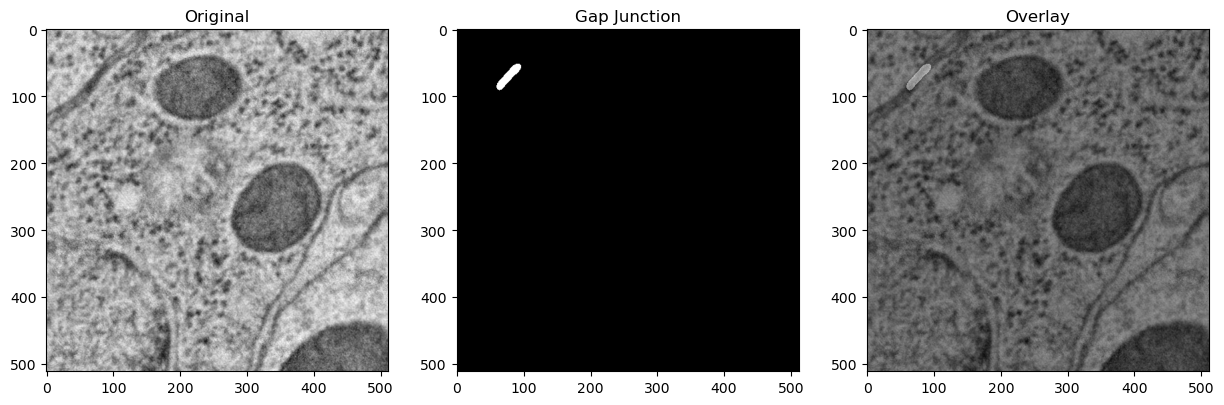

In [56]:
#Test a random image from the dataset
random_path = random.choice(imgs)
random_img = Path(dataset_dir) / random_path
random_pred = cv2.imread(str(Path(output_dir) / re.sub(r'.png$', r'_pred.png', str(random_path))), cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(cv2.imread(random_img, cv2.IMREAD_GRAYSCALE), cmap="gray")
ax[0].set_title('Original')
ax[1].imshow(random_pred, cmap="gray")
ax[1].set_title('Gap Junction')
ax[2].imshow(cv2.imread(random_img, cv2.IMREAD_GRAYSCALE), cmap="gray")
ax[2].imshow(random_pred, cmap="gray", alpha=0.4)
ax[2].set_title('Overlay')

In [53]:
str(Path(dataset_dir) / random.choice(imgs))

'/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/imgs/SEM_dauer_2_image_export_s002_Y7_X9.png.png'

In [ ]:
#Necessary?
def collate_fn(batch):
    return (
        torch.stack([x[0] for x in batch]),
        torch.stack([x[1] for x in batch]),
        torch.stack([x[2] for x in batch]),
        torch.stack([x[3] for x in batch]),
    )